# 第8章: ニューラルネット

第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

## 70. 単語ベクトルの和による特徴量
問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．例えば，学習データについて，すべての事例xiの特徴ベクトルxiを並べた行列Xと，正解ラベルを並べた行列（ベクトル）Yを作成したい．

X=⎛⎝⎜⎜⎜⎜x1x2…xn⎞⎠⎟⎟⎟⎟∈ℝn×d,Y=⎛⎝⎜⎜⎜⎜y1y2…yn⎞⎠⎟⎟⎟⎟∈ℕn
ここで，nは学習データの事例数であり，xi∈ℝdとyi∈ℕはそれぞれ，i∈{1,…,n}番目の事例の特徴量ベクトルと正解ラベルを表す． なお，今回は「ビジネス」「科学技術」「エンターテイメント」「健康」の4カテゴリ分類である．ℕ<4で4未満の自然数（0を含む）を表すことにすれば，任意の事例の正解ラベルyiはyi∈ℕ<4で表現できる． 以降では，ラベルの種類数をLで表す（今回の分類タスクではL=4である）．

i番目の事例の特徴ベクトルxiは，次式で求める．

xi=1Ti∑t=1Tiemb(wi,t)
ここで，i番目の事例はTi個の（記事見出しの）単語列(wi,1,wi,2,…,wi,Ti)から構成され，emb(w)∈ℝdは単語wに対応する単語ベクトル（次元数はd）である．すなわち，i番目の事例の記事見出しを，その見出しに含まれる単語のベクトルの平均で表現したものがxiである．今回は単語ベクトルとして，問題60でダウンロードしたものを用いればよい．300次元の単語ベクトルを用いたので，d=300である．

i番目の事例のラベルyiは，次のように定義する．

yi=⎧⎩⎨⎪⎪0123(記事xiが「ビジネス」カテゴリの場合)(記事xiが「科学技術」カテゴリの場合)(記事xiが「エンターテイメント」カテゴリの場合)(記事xiが「健康」カテゴリの場合)
なお，カテゴリ名とラベルの番号が一対一で対応付いていれば，上式の通りの対応付けでなくてもよい．

以上の仕様に基づき，以下の行列・ベクトルを作成し，ファイルに保存せよ．

学習データの特徴量行列: Xtrain∈ℝNt×d
学習データのラベルベクトル: Ytrain∈ℕNt
検証データの特徴量行列: Xvalid∈ℝNv×d
検証データのラベルベクトル: Yvalid∈ℕNv
評価データの特徴量行列: Xtest∈ℝNe×d
評価データのラベルベクトル: Ytest∈ℕNe
なお，Nt,Nv,Neはそれぞれ，学習データの事例数，検証データの事例数，評価データの事例数である．

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2020-07-29 11:25:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  12.2MB/s    in 2.3s    

2020-07-29 11:25:16 (12.2 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [2]:
import pandas as pd
import sklearn

df = pd.read_csv('newsCorpora.csv', sep='\t', header=None)
df.columns = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP']
df = sklearn.utils.shuffle(df[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail'])])
unit_of_length = len(df) // 10
train = df.iloc[:unit_of_length*8, :]
valid = df.iloc[unit_of_length*8:unit_of_length*9, :]
test = df.iloc[unit_of_length*9:, :]

print(f'all_df_shape: {df.shape}')
print(f'train_shape: {train.shape}')
print(f'valid_shape: {valid.shape}')
print(f'test_shape: {test.shape}')

train.to_csv('train.txt', sep='\t', index=False)
valid.to_csv('valid.txt', sep='\t', index=False)
test.to_csv('test.txt', sep='\t', index=False)

all_df_shape: (13340, 8)
train_shape: (10672, 8)
valid_shape: (1334, 8)
test_shape: (1334, 8)


In [3]:
from gensim.models import KeyedVectors

# 学習済みモデルのロード
model = KeyedVectors.load_word2vec_format('drive/My Drive/GoogleNews-vectors-negative300 (1).bin.gz', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [4]:
def text_to_tensor(x):
  words = x.lower()\
                    .replace('.', '')\
                    .replace(',', '')\
                    .replace("'s", '')\
                    .replace("'", '')\
                    .replace(":", '')\
                    .replace("-", '')\
                    .replace('"','')\
                    .replace('!','')\
                    .replace('?','')\
                    .replace('(','')\
                    .replace(')','')\
                    .split(' ')
  word_vec = None

  for word in words:
    if word not in model:
      continue
    if word_vec is None:
      word_vec = model[word]
    else:
      word_vec = word_vec + model[word]

  return word_vec / len(words)

In [5]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

train_X = np.array([text_to_tensor(text) for text in train['TITLE']])
valid_X = np.array([text_to_tensor(text) for text in valid['TITLE']])
test_X = np.array([text_to_tensor(text) for text in test['TITLE']])

ohe = OneHotEncoder(sparse=False)
train_y = ohe.fit_transform(train['PUBLISHER'].values.reshape(-1,1))
valid_y = ohe.transform(valid['PUBLISHER'].values.reshape(-1,1))
test_y = ohe.transform(test['PUBLISHER'].values.reshape(-1,1))

## 71. 単層ニューラルネットワークによる予測
問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ．

ŷ 1=softmax(x1W),Ŷ =softmax(X[1:4]W)
ただし，softmaxはソフトマックス関数，X[1:4]∈ℝ4×dは特徴ベクトルx1,x2,x3,x4を縦に並べた行列である．

X[1:4]=⎛⎝⎜⎜⎜⎜x1x2x3x4⎞⎠⎟⎟⎟⎟
行列W∈ℝd×Lは単層ニューラルネットワークの重み行列で，ここではランダムな値で初期化すればよい（問題73以降で学習して求める）．なお，ŷ 1∈ℝLは未学習の行列Wで事例x1を分類したときに，各カテゴリに属する確率を表すベクトルである． 同様に，Ŷ ∈ℝn×Lは，学習データの事例x1,x2,x3,x4について，各カテゴリに属する確率を行列として表現している．

In [6]:
import tensorflow as tf

nn = tf.keras.Sequential([
                             tf.keras.layers.Dense(5, input_shape=(300,), activation='softmax')
])
nn.compile(
    loss='categorical_crossentropy',
    optimizer='SGD'
    )

In [7]:
nn(train_X)

<tf.Tensor: shape=(10672, 5), dtype=float32, numpy=
array([[0.22822702, 0.16823924, 0.20663857, 0.2213668 , 0.17552847],
       [0.20521173, 0.21630366, 0.18514465, 0.20585547, 0.1874845 ],
       [0.21735564, 0.19324416, 0.20270616, 0.19535567, 0.19133835],
       ...,
       [0.2030306 , 0.21667965, 0.19679552, 0.20844844, 0.17504579],
       [0.19964592, 0.20010369, 0.19263653, 0.22507763, 0.18253626],
       [0.20010121, 0.20025074, 0.21030244, 0.20725498, 0.18209064]],
      dtype=float32)>

## 72. 損失と勾配の計算
学習データの事例x1と事例集合x1,x2,x3,x4に対して，クロスエントロピー損失と，行列Wに対する勾配を計算せよ．なお，ある事例xiに対して損失は次式で計算される．

li=−log[事例xiがyiに分類される確率]
ただし，事例集合に対するクロスエントロピー損失は，その集合に含まれる各事例の損失の平均とする．

In [8]:
np.mean(tf.keras.losses.categorical_crossentropy(train_y, nn(train_X)))

1.6084025

## 73. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列Wを学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [9]:
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y)).shuffle(len(train)).batch(64)
nn.fit(dataset, epochs=100)

Epoch 1/100
167/167 [==============================] - 0s 1ms/step - loss: 1.5887
Epoch 2/100
167/167 [==============================] - 0s 1ms/step - loss: 1.5602
Epoch 3/100
167/167 [==============================] - 0s 1ms/step - loss: 1.5410
Epoch 4/100
167/167 [==============================] - 0s 1ms/step - loss: 1.5256
Epoch 5/100
167/167 [==============================] - 0s 1ms/step - loss: 1.5118
Epoch 6/100
167/167 [==============================] - 0s 1ms/step - loss: 1.4990
Epoch 7/100
167/167 [==============================] - 0s 1ms/step - loss: 1.4868
Epoch 8/100
167/167 [==============================] - 0s 2ms/step - loss: 1.4752
Epoch 9/100
167/167 [==============================] - 0s 2ms/step - loss: 1.4641
Epoch 10/100
167/167 [==============================] - 0s 2ms/step - loss: 1.4534
Epoch 11/100
167/167 [==============================] - 0s 2ms/step - loss: 1.4432
Epoch 12/100
167/167 [==============================] - 0s 2ms/step - loss: 1.4334
Epoch 13/100


## 74. 正解率の計測
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [10]:
from sklearn.metrics import accuracy_score

def enc_target_vector(x):
  ans = []
  for vec in x:
    vec_li = vec.tolist()
    ans.append(vec_li.index(max(vec_li)))
  return ans

print(f'train_score: {accuracy_score(enc_target_vector(nn.predict(train_X)), enc_target_vector(train_y))}')
print(f'test_score: {accuracy_score(enc_target_vector(nn.predict(test_X)), enc_target_vector(test_y))}')

train_score: 0.5490067466266867
test_score: 0.5412293853073463


## 75. 損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [11]:
nn = tf.keras.Sequential([
                          tf.keras.layers.Dense(5, input_shape=(300,), activation='softmax')
                          ])
epochs = range(20)
train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y)).shuffle(train_X.shape[0]).batch(64)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

train_loss_arr = []
test_loss_arr = []
train_score_arr = []
test_score_arr = []

for epoch in epochs:
  print(f'epoch: {epoch}')
  for step, x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      reconstructed = nn(x_batch_train)
      current_loss = tf.keras.losses.categorical_crossentropy(x_batch_train[1], reconstructed)
    
    grads = tape.gradient(current_loss, nn.trainable_weights)
    optimizer.apply_gradients(zip(grads, nn.trainable_weights))
  
  train_loss_arr.append(np.mean(tf.keras.losses.categorical_crossentropy(train_y, nn(train_X))))
  test_loss_arr.append(np.mean(tf.keras.losses.categorical_crossentropy(test_y, nn(test_X))))
  train_score_arr.append(accuracy_score(enc_target_vector(nn.predict(train_X)), enc_target_vector(train_y)))
  test_score_arr.append(accuracy_score(enc_target_vector(nn.predict(test_X)), enc_target_vector(test_y)))


epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19


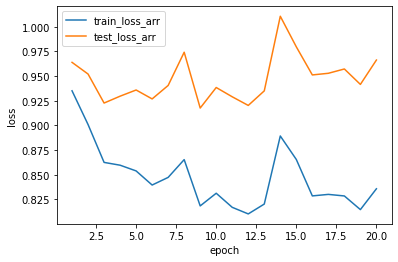

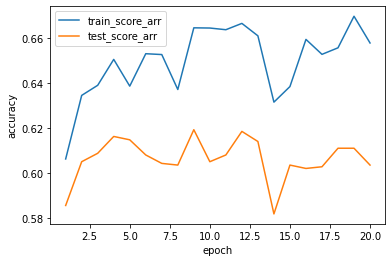

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(train_loss_arr)+1), train_loss_arr, label='train_loss_arr')
plt.plot(range(1,len(test_loss_arr)+1), test_loss_arr, label='test_loss_arr')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(range(1,len(train_score_arr)+1), train_score_arr, label='train_score_arr')
plt.plot(range(1,len(test_score_arr)+1), test_score_arr, label='test_score_arr')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## 76. チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

In [13]:
nn = tf.keras.Sequential([
                          tf.keras.layers.Dense(5, input_shape=(300,), activation='softmax')
                          ])
epochs = range(20)
train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y)).shuffle(train_X.shape[0]).batch(64)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

train_loss_arr = []
test_loss_arr = []
train_score_arr = []
test_score_arr = []

for epoch in epochs:
  print(f'epoch: {epoch}')
  for step, x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      reconstructed = nn(x_batch_train)
      current_loss = tf.keras.losses.categorical_crossentropy(x_batch_train[1], reconstructed)
    
    grads = tape.gradient(current_loss, nn.trainable_weights)
    optimizer.apply_gradients(zip(grads, nn.trainable_weights))
  
  print(nn.trainable_weights)
  print(grads)

epoch: 0
[<tf.Variable 'dense_2/kernel:0' shape=(300, 5) dtype=float32, numpy=
array([[ 0.21555758, -0.03327212,  0.30097985,  0.6598585 , -0.8776647 ],
       [ 0.08250857,  0.032514  , -0.26141942,  0.20750773, -0.23886178],
       [ 0.4936995 , -0.24064165,  0.13524832,  0.25993866, -0.65777844],
       ...,
       [ 0.00362898, -0.23736235, -0.53550524, -0.27435532,  0.827533  ],
       [ 0.00903299, -0.5252937 , -0.08670241,  0.3988883 ,  0.0385859 ],
       [ 0.15605201,  0.50872606,  0.714804  ,  0.6177636 , -1.8726373 ]],
      dtype=float32)>, <tf.Variable 'dense_2/bias:0' shape=(5,) dtype=float32, numpy=
array([-1.3310152 ,  0.97023237,  1.2956089 , -0.92351973, -0.01130158],
      dtype=float32)>]
[<tf.Tensor: shape=(300, 5), dtype=float32, numpy=
array([[ 0.09639551,  0.02261599, -0.01289767, -0.04801644, -0.05809739],
       [-0.00360772, -0.05411739,  0.0866501 ,  0.0304998 , -0.05942482],
       [ 0.11848922,  0.12687784, -0.14230515, -0.04498406, -0.05807781],
       ..

## 77. ミニバッチ化
問題76のコードを改変し，B事例ごとに損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．Bの値を1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ．

In [14]:
import time

for i in range(7):
  start_time = time.time()
  nn = tf.keras.Sequential([
                          tf.keras.layers.Dense(5, input_shape=(300,), activation='softmax')
                          ])
  nn.compile(
      loss='categorical_crossentropy',
      optimizer='SGD'
      )
  train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y)).shuffle(train_X.shape[0]).batch(2**i)
  nn.fit(train_dataset)
  print(f'batch_size: {2**i}, time: {time.time() - start_time}s')

10672/10672 [==============================] - 11s 1ms/step - loss: 1.3274
batch_size: 1, time: 11.464580059051514s
5336/5336 [==============================] - 6s 1ms/step - loss: 1.4167
batch_size: 2, time: 6.352829694747925s
2668/2668 [==============================] - 3s 1ms/step - loss: 1.4812
batch_size: 4, time: 3.3840856552124023s
1334/1334 [==============================] - 2s 1ms/step - loss: 1.5305
batch_size: 8, time: 1.8220367431640625s
667/667 [==============================] - 1s 1ms/step - loss: 1.5676
batch_size: 16, time: 1.159637451171875s
334/334 [==============================] - 0s 1ms/step - loss: 1.5820
batch_size: 32, time: 0.7137060165405273s
167/167 [==============================] - 0s 1ms/step - loss: 1.5937
batch_size: 64, time: 0.5173382759094238s


## 78. GPU上での学習
問題77のコードを改変し，GPU上で学習を実行せよ．

In [15]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

IndexError: ignored

In [ ]:
nn = tf.keras.Sequential([
                          tf.keras.layers.Dense(5, input_shape=(300,), activation='softmax')
                          ])
epochs = range(100)
train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y)).shuffle(train_X.shape[0]).batch(64)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

train_loss_arr = []
test_loss_arr = []
train_score_arr = []
test_score_arr = []

for epoch in epochs:
  print(f'epoch: {epoch}')
  for step, x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      reconstructed = nn(x_batch_train)
      current_loss = tf.keras.losses.categorical_crossentropy(x_batch_train[1], reconstructed)
    
    grads = tape.gradient(current_loss, nn.trainable_weights)
    optimizer.apply_gradients(zip(grads, nn.trainable_weights))
  
  train_loss_arr.append(np.mean(tf.keras.losses.categorical_crossentropy(train_y, nn(train_X))))
  test_loss_arr.append(np.mean(tf.keras.losses.categorical_crossentropy(test_y, nn(test_X))))
  train_score_arr.append(accuracy_score(enc_target_vector(nn.predict(train_X)), enc_target_vector(train_y)))
  test_score_arr.append(accuracy_score(enc_target_vector(nn.predict(test_X)), enc_target_vector(test_y)))


## 79. 多層ニューラルネットワーク
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [ ]:
nn = tf.keras.Sequential([
                          tf.keras.layers.Dense(512, input_shape=(300,), activation='relu'),
                          tf.keras.layers.Dense(512, activation='relu'),
                          tf.keras.layers.Dense(5, activation='softmax'),
                          ])
epochs = range(100)
train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y)).shuffle(train_X.shape[0]).batch(64)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

train_loss_arr = []
test_loss_arr = []
train_score_arr = []
test_score_arr = []

for epoch in epochs:
  print(f'epoch: {epoch}')
  for step, x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      reconstructed = nn(x_batch_train)
      current_loss = tf.keras.losses.categorical_crossentropy(x_batch_train[1], reconstructed)
    
    grads = tape.gradient(current_loss, nn.trainable_weights)
    optimizer.apply_gradients(zip(grads, nn.trainable_weights))
  
  train_loss_arr.append(np.mean(tf.keras.losses.categorical_crossentropy(train_y, nn(train_X))))
  test_loss_arr.append(np.mean(tf.keras.losses.categorical_crossentropy(test_y, nn(test_X))))
  train_score_arr.append(accuracy_score(enc_target_vector(nn.predict(train_X)), enc_target_vector(train_y)))
  test_score_arr.append(accuracy_score(enc_target_vector(nn.predict(test_X)), enc_target_vector(test_y)))


In [ ]:
from sklearn.metrics import accuracy_score

def enc_target_vector(x):
  ans = []
  for vec in x:
    vec_li = vec.tolist()
    ans.append(vec_li.index(max(vec_li)))
  return ans

print(f'train_score: {accuracy_score(enc_target_vector(nn.predict(train_X)), enc_target_vector(train_y))}')
print(f'test_score: {accuracy_score(enc_target_vector(nn.predict(test_X)), enc_target_vector(test_y))}')

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(train_loss_arr)+1), train_loss_arr, label='train_loss_arr')
plt.plot(range(1,len(test_loss_arr)+1), test_loss_arr, label='test_loss_arr')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(range(1,len(train_score_arr)+1), train_score_arr, label='train_score_arr')
plt.plot(range(1,len(test_score_arr)+1), test_score_arr, label='test_score_arr')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# 第9章: RNN, CNN

## 80. ID番号への変換
問題51で構築した学習データ中の単語にユニークなID番号を付与したい．学習データ中で最も頻出する単語に1，2番目に頻出する単語に2，……といった方法で，学習データ中で2回以上出現する単語にID番号を付与せよ．そして，与えられた単語列に対して，ID番号の列を返す関数を実装せよ．ただし，出現頻度が2回未満の単語のID番号はすべて0とせよ．

In [16]:
train.head(2)
train = train.iloc[:len(train)//10, :]

In [17]:
def split_text(x):
  words = x.lower()\
                    .replace('.', '')\
                    .replace(',', '')\
                    .replace("'s", '')\
                    .replace("'", '')\
                    .replace(":", '')\
                    .replace("-", '')\
                    .replace('"','')\
                    .replace('!','')\
                    .replace('?','')\
                    .replace('(','')\
                    .replace(')','')\
                    .split(' ')

  return words

word_dict = {}
for text in train['TITLE']:
  for word in split_text(text):
    if word in word_dict:
      word_dict[word]+=1
    else:
      word_dict[word]=1

In [19]:
filter_word_dict = {}
for k, v in word_dict.items():
  if v>1:
    filter_word_dict[k]=v

word_rank_df = pd.DataFrame({'word': list(filter_word_dict.keys()), 'count': list(filter_word_dict.values())})
word_rank_df.sort_values(by='count', ascending=False, inplace=True)
word_rank_df.head(2)

,word,count
33,,516
13,to,282


In [20]:
word_rank_df = word_rank_df[word_rank_df['word']!='']
word_id_dict = {}
for i, word in enumerate(word_rank_df['word']):
  word_id_dict[word] = i

## 81. RNNによる予測
ID番号で表現された単語列x=(x1,x2,…,xT)がある．ただし，Tは単語列の長さ，xt∈ℝVは単語のID番号のone-hot表記である（Vは単語の総数である）．再帰型ニューラルネットワーク（RNN: Recurrent Neural Network）を用い，単語列xからカテゴリyを予測するモデルとして，次式を実装せよ．

h→0=0,h→t=RNN−→−−(emb(xt),h→t−1),y=softmax(W(yh)h→T+b(y))
ただし，emb(x)∈ℝdwは単語埋め込み（単語のone-hot表記から単語ベクトルに変換する関数），h→t∈ℝdhは時刻tの隠れ状態ベクトル，RNN−→−−(x,h)は入力xと前時刻の隠れ状態hから次状態を計算するRNNユニット，W(yh)∈ℝL×dhは隠れ状態ベクトルからカテゴリを予測するための行列，b(y)∈ℝLはバイアス項である（dw,dh,Lはそれぞれ，単語埋め込みの次元数，隠れ状態ベクトルの次元数，ラベル数である）．RNNユニットRNN−→−−(x,h)には様々な構成が考えられるが，典型例として次式が挙げられる．

RNN−→−−(x,h)=g(W(hx)x+W(hh)h+b(h))
ただし，W(hx)∈ℝdh×dw，W(hh)∈ℝdh×dh,b(h)∈ℝdhはRNNユニットのパラメータ，gは活性化関数（例えばtanhやReLUなど）である．

なお，この問題ではパラメータの学習を行わず，ランダムに初期化されたパラメータでyを計算するだけでよい．次元数などのハイパーパラメータは，dw=300,dh=50など，適当な値に設定せよ（以降の問題でも同様である）．

In [128]:
import numpy as np

def encode_to_id(x):
  if x in word_id_dict:
    return word_id_dict[x]
  else:
    return 0

DEFAULT_LENGTH = len(word_rank_df)

def one_hot_embed(x):
  default = [0]*DEFAULT_LENGTH
  default[x] = 1
  return default

max_length = 0
for text in train['TITLE']:
  length = len(text.split(' '))
  if max_length < length:
    max_length = length

padded_text_list = []
for text in train['TITLE']:
  length = len(text.split(' '))
  if length < max_length:
    for _ in range(max_length - length):
      text+=' UNK'
  padded_text_list.append(text)

embedded_text_list = []
for text in padded_text_list:
  word_seq = []
  words = text.lower()\
              .replace('.', '')\
              .replace(',', '')\
              .replace("'s", '')\
              .replace("'", '')\
              .replace(":", '')\
              .replace("-", '')\
              .replace('"','')\
              .replace('!','')\
              .replace('?','')\
              .replace('(','')\
              .replace(')','')\
              .split(' ')

  for word in words:
    word_seq.append(np.array(one_hot_embed(encode_to_id(word))))

  embedded_text_list.append(np.array(word_seq))

embedded_text_array = np.array(embedded_text_list)

In [129]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(max_length, DEFAULT_LENGTH,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

model(embedded_text_array)

<tf.Tensor: shape=(1067, 5), dtype=float32, numpy=
array([[0.20720577, 0.19534266, 0.20379402, 0.19990145, 0.19375612],
       [0.20649853, 0.19554356, 0.2033038 , 0.20045704, 0.19419704],
       [0.2074739 , 0.19642553, 0.202494  , 0.20018974, 0.19341676],
       ...,
       [0.20624949, 0.1957799 , 0.20300889, 0.20114727, 0.19381441],
       [0.20719191, 0.19573985, 0.20257394, 0.20022446, 0.19426985],
       [0.20734225, 0.19566604, 0.20303161, 0.2004612 , 0.1934989 ]],
      dtype=float32)>

## 82. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題81で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

In [131]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
target = ohe.fit_transform(train['PUBLISHER'].values.reshape(-1,1))
target

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(max_length, DEFAULT_LENGTH,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(
      loss='categorical_crossentropy',
      optimizer='SGD'
      )

dataset = tf.data.Dataset.from_tensor_slices((embedded_text_array, target)).shuffle(len(train)).batch(len(train))
model.fit(dataset, epochs=50)

Epoch 1/50
1/1 [==============================] - 0s 1ms/step - loss: 1.6069
Epoch 2/50
1/1 [==============================] - 0s 1ms/step - loss: 1.6065
Epoch 3/50
1/1 [==============================] - 0s 1ms/step - loss: 1.6060
Epoch 4/50
1/1 [==============================] - 0s 1ms/step - loss: 1.6055
Epoch 5/50
1/1 [==============================] - 0s 1ms/step - loss: 1.6050
Epoch 6/50
1/1 [==============================] - 0s 1ms/step - loss: 1.6046
Epoch 7/50
1/1 [==============================] - 0s 1ms/step - loss: 1.6041
Epoch 8/50
1/1 [==============================] - 0s 1ms/step - loss: 1.6036
Epoch 9/50
1/1 [==============================] - 0s 2ms/step - loss: 1.6032
Epoch 10/50
1/1 [==============================] - 0s 1ms/step - loss: 1.6028
Epoch 11/50
1/1 [==============================] - 0s 1ms/step - loss: 1.6023
Epoch 12/50
1/1 [==============================] - 0s 1ms/step - loss: 1.6019
Epoch 13/50
1/1 [==============================] - 0s 1ms/step - loss: 1.

## 83. ミニバッチ化・GPU上での学習
問題82のコードを改変し，B事例ごとに損失・勾配を計算して学習を行えるようにせよ（Bの値は適当に選べ）．また，GPU上で学習を実行せよ．

In [132]:
from sklearn.preprocessing import OneHotEncoder

B = 32
ohe = OneHotEncoder(sparse=False)
target = ohe.fit_transform(train['PUBLISHER'].values.reshape(-1,1))
target

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(max_length, DEFAULT_LENGTH,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(
      loss='categorical_crossentropy',
      optimizer='SGD'
      )

dataset = tf.data.Dataset.from_tensor_slices((embedded_text_array, target)).shuffle(len(train)).batch(B)
model.fit(dataset, epochs=50)

Epoch 1/50
34/34 [==============================] - 2s 51ms/step - loss: 1.6000
Epoch 2/50
34/34 [==============================] - 2s 50ms/step - loss: 1.5931
Epoch 3/50
34/34 [==============================] - 2s 49ms/step - loss: 1.5884
Epoch 4/50
34/34 [==============================] - 2s 49ms/step - loss: 1.5853
Epoch 5/50
34/34 [==============================] - 2s 48ms/step - loss: 1.5832
Epoch 6/50
34/34 [==============================] - 2s 48ms/step - loss: 1.5819
Epoch 7/50
34/34 [==============================] - 2s 50ms/step - loss: 1.5808
Epoch 8/50
34/34 [==============================] - 2s 49ms/step - loss: 1.5803
Epoch 9/50
34/34 [==============================] - 2s 50ms/step - loss: 1.5800
Epoch 10/50
34/34 [==============================] - 2s 50ms/step - loss: 1.5797
Epoch 11/50
34/34 [==============================] - 2s 49ms/step - loss: 1.5795
Epoch 12/50
34/34 [==============================] - 2s 50ms/step - loss: 1.5792
Epoch 13/50
34/34 [==================

## 84. 単語ベクトルの導入
事前学習済みの単語ベクトル（例えば，Google Newsデータセット（約1,000億単語）での学習済み単語ベクトル）で単語埋め込みemb(x)を初期化し，学習せよ．

In [137]:
from gensim.models import KeyedVectors

# 学習済みモデルのロード
model = KeyedVectors.load_word2vec_format('drive/My Drive/GoogleNews-vectors-negative300 (1).bin.gz', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [134]:
import numpy as np

max_length = 0
for text in train['TITLE']:
  length = len(text.split(' '))
  if max_length < length:
    max_length = length

padded_text_list = []
for text in train['TITLE']:
  length = len(text.split(' '))
  if length < max_length:
    for _ in range(max_length - length):
      text+=' UNK'
  padded_text_list.append(text)

embedded_text_list = []
for text in padded_text_list:
  word_seq = []
  words = text.lower()\
              .replace('.', '')\
              .replace(',', '')\
              .replace("'s", '')\
              .replace("'", '')\
              .replace(":", '')\
              .replace("-", '')\
              .replace('"','')\
              .replace('!','')\
              .replace('?','')\
              .replace('(','')\
              .replace(')','')\
              .split(' ')

  for word in words:
    word_seq.append(model['word'])

  embedded_text_list.append(np.array(word_seq))

embedded_text_array = np.array(embedded_text_list)

In [144]:
embedded_text_array.shape

(1067, 19, 300)

In [138]:
B = 32
ohe = OneHotEncoder(sparse=False)
target = ohe.fit_transform(train['PUBLISHER'].values.reshape(-1,1))
target

nn = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(max_length, 300,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
nn.compile(
      loss='categorical_crossentropy',
      optimizer='SGD'
      )

dataset = tf.data.Dataset.from_tensor_slices((embedded_text_array, target)).shuffle(len(train)).batch(B)
nn.fit(dataset, epochs=50)

Epoch 1/50
34/34 [==============================] - 1s 18ms/step - loss: 1.5860
Epoch 2/50
34/34 [==============================] - 1s 17ms/step - loss: 1.5827
Epoch 3/50
34/34 [==============================] - 1s 18ms/step - loss: 1.5820
Epoch 4/50
34/34 [==============================] - 1s 18ms/step - loss: 1.5814
Epoch 5/50
34/34 [==============================] - 1s 18ms/step - loss: 1.5811
Epoch 6/50
34/34 [==============================] - 1s 18ms/step - loss: 1.5810
Epoch 7/50
34/34 [==============================] - 1s 18ms/step - loss: 1.5814
Epoch 8/50
34/34 [==============================] - 1s 17ms/step - loss: 1.5809
Epoch 9/50
34/34 [==============================] - 1s 18ms/step - loss: 1.5811
Epoch 10/50
34/34 [==============================] - 1s 18ms/step - loss: 1.5809
Epoch 11/50
34/34 [==============================] - 1s 19ms/step - loss: 1.5811
Epoch 12/50
34/34 [==============================] - 1s 17ms/step - loss: 1.5808
Epoch 13/50
34/34 [==================

In [139]:
test_padded_text_list = []
for text in test['TITLE']:
  length = len(text.split(' '))
  if length < max_length:
    for _ in range(max_length - length):
      text+=' UNK'
  test_padded_text_list.append(text)

In [140]:
import numpy as np

test_embedded_text_list = []
for text in test_padded_text_list:
  word_seq = []
  words = text.lower()\
              .replace('.', '')\
              .replace(',', '')\
              .replace("'s", '')\
              .replace("'", '')\
              .replace(":", '')\
              .replace("-", '')\
              .replace('"', '')\
              .replace('!', '')\
              .replace('?', '')\
              .replace('(', '')\
              .replace(')', '')\
              .split(' ')

  for word in words:
    word_seq.append(model['word'])
    if len(word_seq) == max_length:
      break

  test_embedded_text_list.append(np.array(word_seq))

test_embedded_text_array = np.array(test_embedded_text_list)

In [141]:
pred = nn.predict(test_embedded_text_array)

In [142]:
def enc_target_vector(x):
  ans = []
  for vec in x:
    vec_li = vec.tolist()
    ans.append(vec_li.index(max(vec_li)))
  return ans

In [143]:
from sklearn.metrics import accuracy_score
test_target = ohe.transform(test['PUBLISHER'].values.reshape(-1,1))

accuracy_score(enc_target_vector(test_target), enc_target_vector(pred))

0.30434782608695654

## 85. 双方向RNN・多層化
順方向と逆方向のRNNの両方を用いて入力テキストをエンコードし，モデルを学習せよ．

h⃖ T+1=0,h⃖ t=RNN←−−−(emb(xt),h⃖ t+1),y=softmax(W(yh)[h→T;h⃖ 1]+b(y))
ただし，h→t∈ℝdh,h⃖ t∈ℝdhはそれぞれ，順方向および逆方向のRNNで求めた時刻tの隠れ状態ベクトル，RNN←−−−(x,h)は入力xと次時刻の隠れ状態hから前状態を計算するRNNユニット，W(yh)∈ℝL×2dhは隠れ状態ベクトルからカテゴリを予測するための行列，b(y)∈ℝLはバイアス項である．また，[a;b]はベクトルaとbの連結を表す。

さらに，双方向RNNを多層化して実験せよ．

In [145]:
B = 32
ohe = OneHotEncoder(sparse=False)
target = ohe.fit_transform(train['PUBLISHER'].values.reshape(-1,1))
target

nn = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, input_shape=(max_length, 300,))),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
nn.compile(
      loss='categorical_crossentropy',
      optimizer='SGD'
      )

dataset = tf.data.Dataset.from_tensor_slices((embedded_text_array, target)).shuffle(len(train)).batch(B)
nn.fit(dataset, epochs=50)

Epoch 1/50
34/34 [==============================] - 1s 31ms/step - loss: 1.6076
Epoch 2/50
34/34 [==============================] - 1s 30ms/step - loss: 1.5849
Epoch 3/50
34/34 [==============================] - 1s 30ms/step - loss: 1.5818
Epoch 4/50
34/34 [==============================] - 1s 29ms/step - loss: 1.5814
Epoch 5/50
34/34 [==============================] - 1s 29ms/step - loss: 1.5814
Epoch 6/50
34/34 [==============================] - 1s 30ms/step - loss: 1.5813
Epoch 7/50
34/34 [==============================] - 1s 30ms/step - loss: 1.5810
Epoch 8/50
34/34 [==============================] - 1s 30ms/step - loss: 1.5814
Epoch 9/50
34/34 [==============================] - 1s 30ms/step - loss: 1.5811
Epoch 10/50
34/34 [==============================] - 1s 30ms/step - loss: 1.5811
Epoch 11/50
34/34 [==============================] - 1s 29ms/step - loss: 1.5810
Epoch 12/50
34/34 [==============================] - 1s 29ms/step - loss: 1.5812
Epoch 13/50
34/34 [==================

In [146]:
pred = nn.predict(test_embedded_text_array)
accuracy_score(enc_target_vector(test_target), enc_target_vector(pred))

0.30434782608695654

## 86. 畳み込みニューラルネットワーク (CNN)
ID番号で表現された単語列x=(x1,x2,…,xT)がある．ただし，Tは単語列の長さ，xt∈ℝVは単語のID番号のone-hot表記である（Vは単語の総数である）．畳み込みニューラルネットワーク（CNN: Convolutional Neural Network）を用い，単語列xからカテゴリyを予測するモデルを実装せよ．

ただし，畳み込みニューラルネットワークの構成は以下の通りとする．

単語埋め込みの次元数: dw
畳み込みのフィルターのサイズ: 3 トークン
畳み込みのストライド: 1 トークン
畳み込みのパディング: あり
畳み込み演算後の各時刻のベクトルの次元数: dh
畳み込み演算後に最大値プーリング（max pooling）を適用し，入力文をdh次元の隠れベクトルで表現
すなわち，時刻tの特徴ベクトルpt∈ℝdhは次式で表される．

pt=g(W(px)[emb(xt−1);emb(xt);emb(xt+1)]+b(p))
ただし，W(px)∈ℝdh×3dw,b(p)∈ℝdhはCNNのパラメータ，gは活性化関数（例えばtanhやReLUなど），[a;b;c]はベクトルa,b,cの連結である．なお，行列W(px)の列数が3dwになるのは，3個のトークンの単語埋め込みを連結したものに対して，線形変換を行うためである．

最大値プーリングでは，特徴ベクトルの次元毎に全時刻における最大値を取り，入力文書の特徴ベクトルc∈ℝdhを求める．c[i]でベクトルcのi番目の次元の値を表すことにすると，最大値プーリングは次式で表される．

c[i]=max1≤t≤Tpt[i]
最後に，入力文書の特徴ベクトルcに行列W(yc)∈ℝL×dhとバイアス項b(y)∈ℝLによる線形変換とソフトマックス関数を適用し，カテゴリyを予測する．

y=softmax(W(yc)c+b(y))
なお，この問題ではモデルの学習を行わず，ランダムに初期化された重み行列でyを計算するだけでよい．

In [188]:
max_length = 0
for text in train['TITLE']:
  length = len(text.split(' '))
  if max_length < length:
    max_length = length

padded_text_list = []
for text in train['TITLE']:
  length = len(text.split(' '))
  if length < max_length:
    for _ in range(max_length - length):
      text+=' UNK'
  padded_text_list.append(text)

embedded_text_list = []
for text in padded_text_list:
  word_seq = []
  words = text.lower()\
              .replace('.', '')\
              .replace(',', '')\
              .replace("'s", '')\
              .replace("'", '')\
              .replace(":", '')\
              .replace("-", '')\
              .replace('"','')\
              .replace('!','')\
              .replace('?','')\
              .replace('(','')\
              .replace(')','')\
              .split(' ')

  for word in words:
    if word in model:
      word_seq.append([[word_i] for word_i in model[word]])
    else:
      word_seq.append([[word_i] for word_i in [0]*300])

  embedded_text_list.append(np.array(word_seq))

embedded_text_array = np.array(embedded_text_list)

In [209]:
nn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(19, 300, 1)),
    tf.keras.layers.MaxPooling2D((3,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

nn(embedded_text_array)

<tf.Tensor: shape=(1067, 5), dtype=float32, numpy=
array([[0.19125962, 0.20559098, 0.2018827 , 0.20529942, 0.19596726],
       [0.18903656, 0.2060474 , 0.2031538 , 0.20627724, 0.19548497],
       [0.18954653, 0.20931731, 0.20255306, 0.20564069, 0.1929424 ],
       ...,
       [0.19268346, 0.20503305, 0.20423084, 0.20991412, 0.18813853],
       [0.19131082, 0.20806436, 0.1997658 , 0.20496538, 0.19589359],
       [0.19347563, 0.20388947, 0.1992767 , 0.20717154, 0.19618666]],
      dtype=float32)>

## 87. 確率的勾配降下法によるCNNの学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題86で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

In [210]:
nn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(19, 300, 1)),
    tf.keras.layers.MaxPooling2D((3,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
nn.compile(
      loss='categorical_crossentropy',
      optimizer='SGD'
      )

In [211]:
embedded_text_array.shape

(1067, 19, 300, 1)

In [212]:
dataset = tf.data.Dataset.from_tensor_slices((embedded_text_array, target)).shuffle(len(train)).batch(32)
nn.fit(dataset, epochs=50)

Epoch 1/50
34/34 [==============================] - 4s 117ms/step - loss: 1.5876
Epoch 2/50
34/34 [==============================] - 4s 116ms/step - loss: 1.5656
Epoch 3/50
34/34 [==============================] - 4s 116ms/step - loss: 1.5534
Epoch 4/50
34/34 [==============================] - 4s 115ms/step - loss: 1.5401
Epoch 5/50
34/34 [==============================] - 4s 115ms/step - loss: 1.5303
Epoch 6/50
34/34 [==============================] - 4s 116ms/step - loss: 1.5175
Epoch 7/50
34/34 [==============================] - 4s 114ms/step - loss: 1.5060
Epoch 8/50
34/34 [==============================] - 4s 115ms/step - loss: 1.4946
Epoch 9/50
34/34 [==============================] - 4s 116ms/step - loss: 1.4806
Epoch 10/50
34/34 [==============================] - 4s 115ms/step - loss: 1.4693
Epoch 11/50
34/34 [==============================] - 4s 115ms/step - loss: 1.4543
Epoch 12/50
34/34 [==============================] - 4s 116ms/step - loss: 1.4422
Epoch 13/50
34/34 [======

In [213]:
test_embedded_text_list = []
for text in test_padded_text_list:
  word_seq = []
  words = text.lower()\
              .replace('.', '')\
              .replace(',', '')\
              .replace("'s", '')\
              .replace("'", '')\
              .replace(":", '')\
              .replace("-", '')\
              .replace('"', '')\
              .replace('!', '')\
              .replace('?', '')\
              .replace('(', '')\
              .replace(')', '')\
              .split(' ')

  for word in words:
    if word in model:
      word_seq.append([[word_i] for word_i in model[word]])
    else:
      word_seq.append([[word_i] for word_i in [0]*300])
    if len(word_seq) == max_length:
      break

  test_embedded_text_list.append(np.array(word_seq))

test_embedded_text_array = np.array(test_embedded_text_list)

In [208]:
pred = nn.predict(test_embedded_text_array)
accuracy_score(enc_target_vector(test_target), enc_target_vector(pred))

0.6101949025487257

## 88. パラメータチューニング
問題85や問題87のコードを改変し，ニューラルネットワークの形状やハイパーパラメータを調整しながら，高性能なカテゴリ分類器を構築せよ．

## 89. 事前学習済み言語モデルからの転移学習
事前学習済み言語モデル（例えばBERTなど）を出発点として，ニュース記事見出しをカテゴリに分類するモデルを構築せよ．

In [216]:
!pip install -q tf-nightly
!pip install -q tf-models-nightly

     |████████████████████████████████| 325.0MB 47kB/s 
     |████████████████████████████████| 6.7MB 39.2MB/s 
     |████████████████████████████████| 460kB 49.5MB/s 
     |████████████████████████████████| 870kB 8.3MB/s 
     |████████████████████████████████| 36.4MB 87kB/s 
     |████████████████████████████████| 358kB 46.8MB/s 
     |████████████████████████████████| 1.1MB 45.8MB/s 
     |████████████████████████████████| 102kB 9.4MB/s 
     |████████████████████████████████| 174kB 49.1MB/s 
     |████████████████████████████████| 296kB 44.0MB/s 


In [220]:
!pip list | grep tensorflow

tensorflow                    2.2.0              
tensorflow-addons             0.8.3              
tensorflow-datasets           2.1.0              
tensorflow-estimator          2.2.0              
tensorflow-gcs-config         2.2.0              
tensorflow-hub                0.8.0              
tensorflow-metadata           0.22.2             
tensorflow-model-optimization 0.4.0              
tensorflow-privacy            0.2.2              
tensorflow-probability        0.10.0             


In [222]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

ImportError: ignored